In [154]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gp
from geopandas import GeoDataFrame
from shapely.geometry import LineString
import networkx as nx
import os.path
from os import path
import pathlib
import pandas as pd
from datetime import datetime

from OSMPythonTools.api import Api as osm_api
ox.config(log_console=True, use_cache=True)

In [202]:
speed_df = pd.read_csv('../data/Uber_speeds/movement-speeds-hourly-berlin-2020-1.csv')
#speed_df

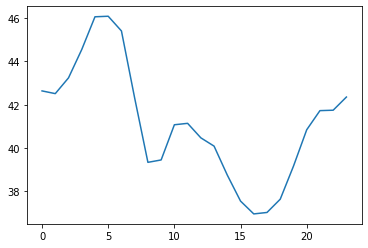

In [203]:
#speed_df = speed_df[speed_df['osm_way_id'] == 28496022]
speed_df = speed_df.sort_values('utc_timestamp')
speed_df = speed_df.groupby(['utc_timestamp','osm_way_id']).mean().reset_index()

speed_df['weekday'] = [datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.000Z').weekday() for time in speed_df['utc_timestamp']]
#speed_df = speed_df[is_weekday]




plt.plot(speed_df.groupby(['hour']).mean()['speed_kph_mean'])

{'cycleway:both': 'no', 'highway': 'secondary', 'lit': 'yes', 'maxspeed': '50', 'name': 'Hermannstraße', 'name:etymology:wikidata': 'Q68880', 'name:etymology:wikipedia': 'de:Arminius', 'parking:lane:both': 'parallel', 'parking:lane:both:parallel': 'on_street', 'postal_code': '12049', 'sidewalk': 'separate', 'smoothness': 'good', 'surface': 'asphalt', 'wikidata': 'Q640045', 'wikipedia': 'de:Hermannstraße (Berlin-Neukölln)'}


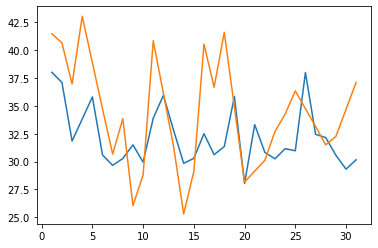

In [182]:
way_id = 28496022

api = osm_api()
way = api.query('way/{}'.format(way_id))

print(way.tags())

#speed_df.sort_values('utc_timestamp')

day_avg = speed_df.groupby(['day']).mean().reset_index()
morning_avg = speed_df[speed_df['hour'].isin(range(6,9))].groupby(['day']).mean().reset_index()

#avg_speed = day_avg['speed_kph_mean']
#avg_speed = speed_df['speed_kph_mean']
#timestamp = speed_df['utc_timestamp']

plt.plot(day_avg['day'], day_avg['speed_kph_mean'])
plt.plot(morning_avg['day'], morning_avg['speed_kph_mean'])
plt.show()

In [88]:
way_id = 385627960

api = osm_api()
way = api.query('way/{}'.format(way_id))

way.tags()['maxspeed']

'50'

In [8]:
G = ox.graph_from_place('Berlin, DE', network_type="drive")

In [61]:
osm_id_df = speed_df[['osm_way_id','osm_start_node_id','osm_end_node_id','speed_kph_mean']]
osm_id_df = osm_id_df.groupby(['osm_start_node_id','osm_end_node_id']).mean().reset_index()
in_graph = [ id_start in G.nodes and id_end in G.nodes and id_end in G[id_start].keys() for id_start, id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

osm_id_df = osm_id_df[in_graph]

#osm_id_df = osm_id_df[:100]

osm_id_df['osm_segment'] = [G.edges[id_start,id_end,0] for id_start,id_end in zip(osm_id_df['osm_start_node_id'], osm_id_df['osm_end_node_id'])]

has_geometry = ['geometry' in way.keys() for way in osm_id_df['osm_segment']]
has_maxspeed = ['maxspeed' in way.keys() for way in osm_id_df['osm_segment']]
osm_id_df['maxspeed'] = [segment['maxspeed'] if has_maxspeed[i] else 0 for i,(segment,start,end) in enumerate(zip(osm_id_df['osm_segment'],osm_id_df['osm_start_node_id'],osm_id_df['osm_end_node_id']))]
osm_id_df['speed_percent'] = osm_id_df['speed_kph_mean'] / [float(speed) if type(speed) in [str,int] else float(max(speed)) for speed in osm_id_df['maxspeed']]


#osm_id_df = osm_id_df[has_geometry]
osm_id_df['street'] = [ segment['name'] if 'name' in segment.keys() else str(segment.keys())  for segment in osm_id_df['osm_segment']]

osm_id_df
#osm_id_df[['osm_segment','speed_percent','maxspeed']]


,osm_start_node_id,osm_end_node_id,osm_way_id,speed_kph_mean,osm_segment,maxspeed,speed_percent,street
4,172546,530313,24295532,42.823000,"{'osmid': 24295532, 'name': 'Emmentaler Straße...",50,0.856460,Emmentaler Straße
5,172546,28345850,4638312,33.443000,"{'osmid': 4638312, 'oneway': True, 'name': 'Em...",50,0.668860,Emmentaler Straße
10,172562,530351,4804203,32.428692,"{'osmid': 4804203, 'oneway': True, 'lanes': '2...",50,0.648574,"dict_keys(['osmid', 'oneway', 'lanes', 'highwa..."
14,172564,21509247,27606741,37.198467,"{'osmid': 27606741, 'oneway': True, 'lanes': '...",50,0.743969,Kurt-Schumacher-Platz
17,172587,29493004,31910522,47.428179,"{'osmid': 31910522, 'oneway': True, 'lanes': '...",50,0.948564,Lindauer Allee
...,...,...,...,...,...,...,...,...
26387,6298976090,6298973779,172421115,40.474000,"{'osmid': 172421115, 'oneway': False, 'lanes':...",30,1.349133,Buckower Damm
26465,6366276983,29789747,385888165,37.521647,"{'osmid': 385888165, 'oneway': True, 'lanes': ...",50,0.750433,Urbanstraße
26485,6400342990,6400342991,559214567,33.168791,"{'osmid': 559214567, 'lanes': '3', 'name': 'Wi...",50,0.663376,Wilhelmstraße
26487,6400342991,6400342990,559214567,24.315226,"{'osmid': 559214567, 'lanes': '3', 'name': 'Wi...",50,0.486305,Wilhelmstraße


In [21]:
##geometry = [row['geometry'] if row[has_geometry] else 0 for i,row in enumerate(osm_id_df['osm_segment'])]
geometry = [segment['geometry'] if has_geometry[i] else LineString([(G.nodes[start]['x'],G.nodes[start]['y']),(G.nodes[end]['x'],G.nodes[end]['y'])]) for i,(segment,start,end) in enumerate(zip(osm_id_df['osm_segment'],osm_id_df['osm_start_node_id'],osm_id_df['osm_end_node_id']))]


#geometry
#max_speed

In [ ]:

#geometry

geo_df = GeoDataFrame(osm_id_df['speed_kph_mean'], geometry=geometry)
geo_df.to_file("../results/uber_mean_speed.geojson", driver='GeoJSON')

In [142]:
26904555 in G.nodes

True

In [43]:
G.nodes[172594]

{'y': 52.5703344, 'x': 13.3608121, 'osmid': 172594}

In [11]:
G[40817197]

KeyError: 40817197

In [9]:
G.edges[172594,223826118,0]

{'osmid': 40817197,
 'name': 'Emmentaler Straße',
 'highway': 'secondary',
 'maxspeed': '50',
 'oneway': False,
 'length': 11.758}

In [152]:
27587520 in G[26904555].keys()

True

In [ ]:
#zip the coordinates into a point object and convert to a GeoData Frame
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = GeoDataFrame(df, geometry=geometry)

# aggregate these points with the GrouBy
geo_df = geo_df.groupby(['track_seg_point_id', 'Hour'])['geometry'].apply(lambda x: LineString(x.tolist()))
geo_df = GeoDataFrame(geo_df, geometry='geometry')

In [54]:
 = G.datafr

AttributeError: 'MultiDiGraph' object has no attribute 'datafr'

In [145]:
#nodes, edges = ox.graph_to_gdfs(G)

#edges = edges.drop(columns=['access','service','tunnel','junction','width','est_width','area','oneway','lanes','bridge','ref','name','highway','u','v','key'])
##edges
##geo_edges = GeoDataFrame(edges, geometry='geometry')
edges['osmid'] = [id if type(id)==int else id[0] for id in edges['osmid']]
edges['maxspeed'] = [speed[0] if type(speed)==list else speed for speed in edges['maxspeed']]
edges['maxspeed'] = [50.0 if speed=="DE:urban" else speed for speed in edges['maxspeed']]
edges['maxspeed'] = [8.0 if speed=="walk" or speed=="5 mph" else float(speed) for speed in edges['maxspeed']]
edges.dropna().to_file("../results/berlin_max_speed.geojson", driver='GeoJSON')



In [146]:
edges.dropna().head(50)

,osmid,maxspeed,length,geometry
0,4610047,50.0,21.907,"LINESTRING (13.33550 52.56521, 13.33560 52.565..."
1,5117633,50.0,52.407,"LINESTRING (13.33550 52.56521, 13.33565 52.565..."
2,31740296,50.0,280.903,"LINESTRING (13.33550 52.56521, 13.33533 52.565..."
3,24973218,50.0,17.179,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)"
4,40817055,50.0,12.127,"LINESTRING (13.34661 52.56703, 13.34643 52.56701)"
5,4546470,50.0,29.417,"LINESTRING (13.34661 52.56703, 13.34659 52.567..."
6,4638312,50.0,13.228,"LINESTRING (13.35225 52.56774, 13.35207 52.56771)"
7,24295532,50.0,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)"
8,4610047,50.0,30.920,"LINESTRING (13.33956 52.56408, 13.34000 52.56399)"
9,4674699,30.0,27.089,"LINESTRING (13.33956 52.56408, 13.33944 52.56385)"
